In [1]:
import pandas as pd
import openml
from openml.datasets import edit_dataset, fork_dataset, get_dataset

data = openml.datasets.get_dataset(41156)

X, y, categorical_indicator, attribute_names = data.get_data(
    target=data.default_target_attribute, dataset_format="dataframe"
)

In [2]:
nominal = [b for a, b in zip(categorical_indicator, attribute_names) if a]
dummied_data = pd.get_dummies(X, columns=nominal)

columns = dummied_data.columns
updates = {}
for col in columns:
    if any(x in col for x in set(('[', ']', '=', '>', '<', ' ', '/', '(', ')', '-', '?'))):
        updates[col] = col.replace('?', '_').replace('-', '_').replace(')', '_').replace('(', '_').replace(' ', '_').replace(',', '_').replace('[', '_').replace(']', '_').replace('<', 'less').replace('>', 'greater').replace('=', 'equal').replace('/', '_')
dummied_data = dummied_data.rename(columns=updates)

dummied_data.fillna(0, inplace=True)
dummied_data

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48
0,0,1,1,32.0,0,0,0,1,0,0.0,...,0,404.0,1,0,0,0,0,0,0,0
1,0,0,1,133.0,0,0,1,0,0,0.0,...,0,242.0,0,0,0,0,0,0,0,0
2,0,0,0,109.0,0,0,0,1,0,0.0,...,0,404.0,1,0,0,0,0,0,0,0
3,0,0,0,113.0,0,0,0,1,0,0.0,...,0,404.0,0,0,0,1,0,1,0,0
4,0,0,0,120.0,0,0,0,1,0,0.0,...,0,303.0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,0,0,0,50.0,1,0,0,1,1,0.0,...,0,404.0,0,0,0,0,0,0,0,1
4143,0,0,0,144.0,0,0,0,1,1,0.0,...,0,404.0,1,0,0,0,0,0,0,0
4144,0,0,0,129.0,0,0,0,0,0,0.0,...,0,353.0,1,1,0,0,0,0,0,0
4145,0,0,0,225.0,0,0,1,1,0,0.0,...,0,303.0,0,0,0,0,0,0,0,0


In [3]:
y

0       0
1       0
2       0
3       1
4       0
       ..
4142    0
4143    0
4144    0
4145    0
4146    1
Name: class, Length: 4147, dtype: category
Categories (2, object): ['0' < '1']

In [4]:
mapping = {'1': 1, '0': 0}
y = y.replace(mapping)

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, left_out, y_train, y_left_out = train_test_split(dummied_data, y, test_size=0.4, random_state=42)
X_test, X_dev, y_test, y_dev = train_test_split(left_out, y_left_out, test_size=0.5, random_state=42)

print(f'train shape: {X_train.shape}\n test shape: {X_test.shape}\n dev shape: {X_dev.shape}')

train shape: (2488, 48)
 test shape: (829, 48)
 dev shape: (830, 48)


In [6]:
drop_list = [col for col in X_train.columns if sum(X_train[col]) <= 0]

X_train.drop(drop_list, axis=1, inplace=True)
X_test.drop(drop_list, axis=1, inplace=True)
X_dev.drop(drop_list, axis=1, inplace=True)
print(f'{len(drop_list)} columns dropped')
print(f'train shape: {X_train.shape}\n test shape: {X_test.shape}\n dev shape: {X_dev.shape}')

2 columns dropped
train shape: (2488, 46)
 test shape: (829, 46)
 dev shape: (830, 46)


In [29]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

xg_boost = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False)

clf = GridSearchCV(xg_boost,{'learning_rate': [1.0, 0.1, 0.01, 0.001],
                        'max_depth': [70000],
                        'n_estimators': [100, 250, 500],
                       'reg_lambda': [10, 1, 0.1, 0.01, 0.001]}, 
                        verbose=2, 
                        error_score='raise')

clf.fit(X_train, y_train)
print(clf.best_score_, clf.best_params_)
xgb_clf = clf

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[15:49:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=100, reg_lambda=10; total time=   0.0s
[15:49:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=100, reg_lambda=10; total time=   0.0s
[15:49:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the ol

[CV] END learning_rate=1.0, max_depth=70000, n_estimators=100, reg_lambda=0.001; total time=   0.0s
[15:49:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:49:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:49:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_

[CV] END learning_rate=1.0, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.1s
[15:49:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.1s
[15:49:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=1.0, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.1s
[15:49:58] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

[CV] END learning_rate=0.1, max_depth=70000, n_estimators=100, reg_lambda=10; total time=   0.0s
[15:50:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.0s
[15:50:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.0s
[15:50:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metri

[CV] END learning_rate=0.1, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=250, reg_lambda=1; total time=   0.1s
[15:50:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metr

[CV] END learning_rate=0.1, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.1s
[15:50:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.1, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_met

[CV] END learning_rate=0.01, max_depth=70000, n_estimators=100, reg_lambda=10; total time=   0.1s
[15:50:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.0s
[15:50:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.0s
[15:50:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_me

[CV] END learning_rate=0.01, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=250, reg_lambda=1; total time=   0.1s
[15:50:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_m

[CV] END learning_rate=0.01, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_

[CV] END learning_rate=0.001, max_depth=70000, n_estimators=100, reg_lambda=10; total time=   0.1s
[15:50:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.0s
[15:50:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=100, reg_lambda=1; total time=   0.1s
[15:50:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval

[CV] END learning_rate=0.001, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=250, reg_lambda=10; total time=   0.1s
[15:50:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=250, reg_lambda=1; total time=   0.1s
[15:50:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eva

[CV] END learning_rate=0.001, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.001, max_depth=70000, n_estimators=500, reg_lambda=10; total time=   0.2s
[15:50:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set ev

[15:36:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB test_acc: 0.8528347406513872
recall: 0.78938225505317
precision: 0.7958226839711886
f_score: 0.7925084934924256



/home/amak2/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


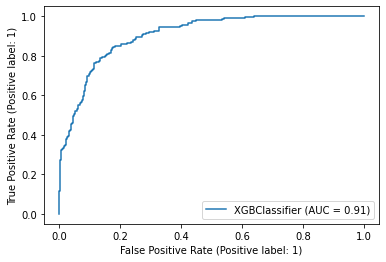

In [7]:
import xgboost as xgb
from sklearn.metrics import f1_score, precision_score, recall_score
from helper_func import plot_roc

xg_boost = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, 
                             learning_rate=0.1, max_depth=7000, n_estimators= 250, reg_lambda=1)

xgb_clf = xg_boost.fit(X_train, y_train)
test_ac = xgb_clf.score(X_test, y_test)
pred = xgb_clf.predict(X_test)
f_score = f1_score(y_test, pred, average='macro')
prec = precision_score(y_test, pred, average='macro')
recall = recall_score(y_test, pred, average='macro')

print(f'XGB test_acc: {test_ac}\nrecall: {recall}\nprecision: {prec}\nf_score: {f_score}\n')
plot_roc(xgb_clf, X_test, y_test)

[15:36:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB test_acc: 0.8528347406513872
recall: 0.78938225505317
precision: 0.7958226839711886
f_score: 0.7925084934924256



/home/amak2/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


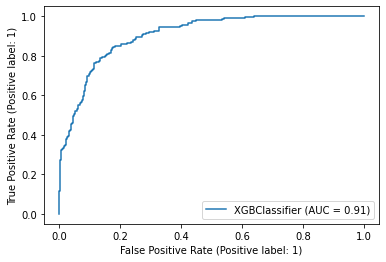

In [8]:
names = list(X_train.columns)
values = list(xgb_clf.feature_importances_)

assert len(names) == len(values)

important_features = [p[0] for p in zip(names, values) if p[1] > 0]

to_drop = []
for cl in names:
    if cl not in important_features:
        to_drop.append(cl)

    
X_train.drop(to_drop, axis=1, inplace=True)

X_test.drop(to_drop, axis=1, inplace=True)
X_dev.drop(to_drop, axis=1, inplace=True)

clf = xg_boost.fit(X_train, y_train)

test_ac = clf.score(X_test, y_test)
pred = clf.predict(X_test)
f_score = f1_score(y_test, pred, average='macro')
prec = precision_score(y_test, pred, average='macro')
recall = recall_score(y_test, pred, average='macro')

print(f'XGB test_acc: {test_ac}\nrecall: {recall}\nprecision: {prec}\nf_score: {f_score}\n')
plot_roc(clf, X_test, y_test)

In [9]:
import lime
import lime.lime_tabular
from __future__ import print_function
np.random.seed(1)
    
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=list(X_train.columns), 
                                                   class_names=['0', '1'])

In [10]:
from multiprocessing import Pool, cpu_count, Queue
from helper_func import *

num_cores = cpu_count()
print(f'num of cores: {num_cores}')
        
if len(intervals_dict) == 0:
        compute_intervals(intervals_dict, X_train)

num of cores: 16


In [11]:
from mlxtend.frequent_patterns import apriori, association_rules
from tqdm import tqdm
import math

pred = xgb_clf.predict(X_dev)

pos_label = '1'
neg_label = '0'

itemset = set()
encoded_vals = []
summed_values = {}
num_features = X_train.shape[1]

shap_threshold = 0.001

p = Pool(num_cores)

for feature in X_train.columns.to_list():
    if feature in intervals_dict:
        intervals = intervals_dict[feature]
        for interval in intervals:
            if interval != interval: continue
            left = interval.left
            right = interval.right
            name = f'{left}<{feature}<={right}'
            itemset.add(name)
    else:
        itemset.add(feature)

itemset.add(pos_label)
itemset.add(neg_label)

for indx in tqdm(range(len(pred))):
    
    pos_queue.put(pos_label)
    neg_queue.put(neg_label)
    
    exp = explainer.explain_instance(X_dev.values[indx], clf.predict_proba, num_features=num_features)
    lime_names = [clean_name(name) for name, val in exp.as_list()]
    lime_vals = [val for name, val in exp.as_list()]
    
    instance_features = X_dev.iloc[[indx]].to_dict(orient='records')[0]
    feature_vals = [instance_features[name] for name in lime_names]
    
    zipped = zip(lime_vals, feature_vals,
                 lime_names, [shap_threshold]*len(lime_names))

    p.map(get_relevant_features, zipped)
    
    append_to_encoded_vals(pos_queue, itemset, encoded_vals)
    append_to_encoded_vals(neg_queue, itemset, encoded_vals)

ohe_df = pd.DataFrame(encoded_vals)


100%|██████████| 830/830 [43:58<00:00,  3.18s/it]


In [12]:
ohe_df

,129.6<V10<=259.2,V7,188.19<V25<=351.0,V35,207.8<V40<=405.6,V29,V6,V33,V45,374.2<V4<=554.8,...,-0.999<V32<=199.8,-0.648<V10<=129.6,405.6<V40<=603.4,V9,351.0<V25<=513.0,V2,V26,1,V18,V31
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,0,1,0,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,1,1,0
3,0,1,0,1,0,1,1,1,1,0,...,0,0,0,0,0,1,1,0,0,1
4,0,0,0,0,0,1,1,0,0,0,...,1,1,0,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1655,0,1,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1656,0,0,0,0,0,0,1,0,0,0,...,1,1,0,1,0,1,1,1,1,1
1657,0,1,1,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1658,0,0,0,0,0,1,1,1,0,0,...,1,1,0,1,1,1,0,1,1,1


In [13]:
freq_items = apriori(ohe_df, min_support=(10/len(pred)), use_colnames=True, max_len=3)
all_rules = association_rules(freq_items, metric="confidence", min_threshold=0.7, support_only=False)

freq_items = apriori(ohe_df.loc[ohe_df[pos_label] == 1], min_support=(10/len(pred)), use_colnames=True, max_len=3)
pos_rules = association_rules(freq_items, metric="confidence", min_threshold=0.6, support_only=False)

freq_items = apriori(ohe_df.loc[ohe_df[neg_label] == 1], min_support=(10/len(pred)), use_colnames=True, max_len=3)
neg_rules = association_rules(freq_items, metric="confidence", min_threshold=0.6, support_only=False)

In [14]:
positive = all_rules[all_rules['consequents'] == {pos_label}]
positive = positive[positive['confidence'] == 1]
positive = positive.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

positive = positive.reset_index(drop=True)
print(len(positive))
for i in positive.index:
    new_rule = positive.loc[[i]]['antecedents'].values[0]
    
    for seen_rule in seen:
        if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add(new_rule)

positive.drop(positive.index[indexes_to_drop], inplace=True )
print(len(positive))

310
12


In [15]:
negative = all_rules[all_rules['consequents'] == {neg_label}]
negative = negative[negative['confidence'] == 1]

negative = negative.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

negative = negative.reset_index(drop=True)
print(len(negative))
for i in negative.index:
    new_rule = negative.loc[[i]]['antecedents'].values[0]
    
    for seen_rule in seen:
        if seen_rule.issubset(new_rule):#new_rule.issubset(seen_rule) or seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add(new_rule)

negative.drop(negative.index[indexes_to_drop], inplace=True )
print(len(negative))

270
36


In [16]:
positive['num-items'] = positive['antecedents'].map(lambda x: len(x))
negative['num-items'] = negative['antecedents'].map(lambda x: len(x))
positive['consequents'] = positive['consequents'].map(lambda x: pos_label)
negative['consequents'] = negative['consequents'].map(lambda x: neg_label)

both = positive.append(negative, ignore_index=True)

discr_rules = both[['antecedents', 'consequents', 'num-items', 'support', 'confidence', 'antecedent support']].sort_values(
    ['support', 'confidence', 'num-items'], ascending=[False, False, False])

discr_rules = discr_rules.rename(columns={"antecedents": "itemset", "consequents": "label"})

discr_rules

,itemset,label,num-items,support,confidence,antecedent support
0,(V44),1,1,0.500000,1.0,0.500000
1,(V46),1,1,0.500000,1.0,0.500000
2,(V9),1,1,0.500000,1.0,0.500000
3,(V18),1,1,0.500000,1.0,0.500000
12,(V13),0,1,0.500000,1.0,0.500000
13,(V5),0,1,0.500000,1.0,0.500000
14,(V42),0,1,0.500000,1.0,0.500000
15,(V16),0,1,0.498193,1.0,0.498193
4,(-0.999<V32<=199.8),1,1,0.496988,1.0,0.496988
16,"(V35, V17)",0,2,0.483735,1.0,0.483735


In [21]:
rev_positive = pos_rules[pos_rules['antecedents'] == {pos_label}]
rev_positive = rev_positive[rev_positive['confidence'] >= 0.7]
rev_positive = rev_positive.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

rev_positive = rev_positive.reset_index(drop=True)
print(len(rev_positive))
for i in rev_positive.index:
    new_rule = rev_positive.loc[[i]]['consequents'].values[0]
    
    for seen_rule, indx in seen:
        if seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add((new_rule, i))

rev_positive.drop(rev_positive.index[indexes_to_drop], inplace=True )
print(len(rev_positive))



rev_negative = neg_rules[neg_rules['antecedents'] == {neg_label}]
rev_negative = rev_negative[rev_negative['confidence'] >= 0.7]
rev_negative = rev_negative.sort_values(['confidence', 'support'], ascending=[False, False])

seen = set()
dropped = set()
indexes_to_drop = []

rev_negative = rev_negative.reset_index(drop=True)
print(len(rev_negative))
for i in rev_negative.index:
    new_rule = rev_negative.loc[[i]]['consequents'].values[0]
    
    for seen_rule, indx in seen:
        if seen_rule.issubset(new_rule):
            indexes_to_drop.append(i)
            break
    else:
        seen.add((new_rule, i))

rev_negative.drop(rev_negative.index[indexes_to_drop], inplace=True )
print(len(rev_negative))

57
11
84
13


In [22]:
rev_positive['num-items'] = rev_positive['consequents'].map(lambda x: len(x))
rev_negative['num-items'] = rev_negative['consequents'].map(lambda x: len(x))
rev_positive['antecedents'] = rev_positive['antecedents'].map(lambda x: pos_label)
rev_negative['antecedents'] = rev_negative['antecedents'].map(lambda x: neg_label)

rev_both = rev_positive.append(rev_negative, ignore_index=True)

chr_rules = rev_both[['antecedents', 'consequents', 'num-items', 'support', 
                          'confidence', 'consequent support']].sort_values(
    ['support', 'confidence', 'num-items'], ascending=[False, False, False])

chr_rules = chr_rules.rename(columns={"antecedents": "label", "consequents": "itemset"})

chr_rules

,label,itemset,num-items,support,confidence,consequent support
0,1,(V44),1,1.000000,1.000000,1.000000
1,1,(V46),1,1.000000,1.000000,1.000000
2,1,(V9),1,1.000000,1.000000,1.000000
3,1,(V18),1,1.000000,1.000000,1.000000
11,0,(V13),1,1.000000,1.000000,1.000000
12,0,(V5),1,1.000000,1.000000,1.000000
13,0,(V42),1,1.000000,1.000000,1.000000
14,0,(V16),1,0.996386,0.996386,0.996386
4,1,(-0.999<V32<=199.8),1,0.993976,0.993976,0.993976
15,0,(V35),1,0.985542,0.985542,0.985542


100%|██████████| 829/829 [00:02<00:00, 299.24it/s]
Acc: 0.8709288299155609
macro rules recall: 0.8094026952567464
macro rules prec: 0.8178969715571927
macro rules f1_score: 0.8135085074667658
188 181


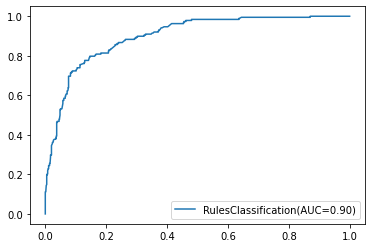

[0.2817133263222955]
coverage: 1.00


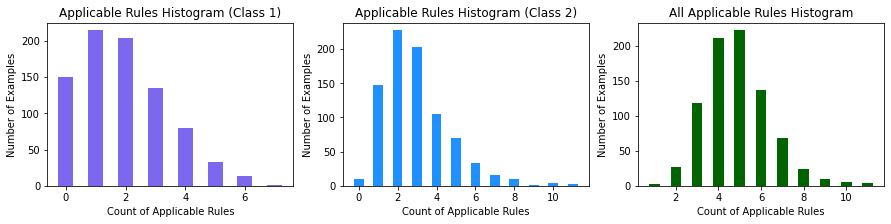

In [23]:
from rules_model import *

dev_pred = xgb_clf.predict(X_dev)
rules_model = RulesModel(ohe_df, discr_rules, y_dev, pos_label, neg_label)

test_pred = xgb_clf.predict(X_test)
rules_test_sol = rules_model.eval_rules(X_test, test_pred, alpha=10, beta =1, decision_thr=0.97)

100%|██████████| 829/829 [00:02<00:00, 290.00it/s]
Acc: 0.8202653799758746
macro rules recall: 0.8236299664752547
macro rules prec: 0.7569373072970196
macro rules f1_score: 0.776155863266264
188 273


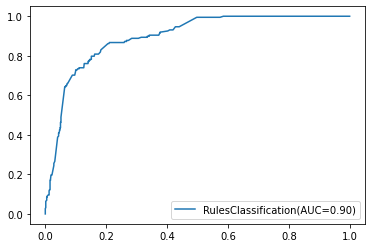

[0.04107975860082796]
coverage: 1.00


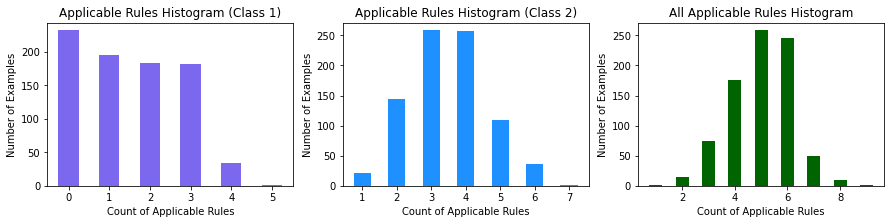

In [24]:
rules_model = RulesModel(ohe_df, chr_rules, y_dev, pos_label, neg_label)

test_pred = xgb_clf.predict(X_test)
rules_test_sol = rules_model.eval_rules(X_test, test_pred, alpha=30, beta=1, decision_thr=0.041)